In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import folium

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from imblearn.over_sampling import SMOTE



- Name: Jack Mannix
- Cohort: Flatiron Data Science - April 2021
- Instructor : Abhineet Kulkarn

# Importing

In [7]:
df_values = pd.read_csv('data/values.csv')
df_labels = pd.read_csv('data/labels.csv')

df = pd.merge(df_values, df_labels, on='id')


# Business Problem

A nonprofit wants to improve access to water across Tanzania. To do so, the nonprofit wants to be able to send alerts to the entities in charge of an individual to check the status of said well. These alerts will be sent when a well is deemed 'in need of repair' or 'non-functioning'. With this goal in mind, the nonprofit needs an algorithm that can accurately predict when the wells should be checked. 

# SCRUBBING

In [8]:
df.drop('id', axis=1, inplace=True)

In [9]:
df.isna().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   date_recorded          59400 non-null  object 
 2   funder                 55765 non-null  object 
 3   gps_height             59400 non-null  int64  
 4   installer              55745 non-null  object 
 5   longitude              59400 non-null  float64
 6   latitude               59400 non-null  float64
 7   wpt_name               59400 non-null  object 
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  subvillage             59029 non-null  object 
 11  region                 59400 non-null  object 
 12  region_code            59400 non-null  int64  
 13  district_code          59400 non-null  int64  
 14  lga                    59400 non-null  object 
 15  wa

#### Null Values

Dropping null values results in the loss of approx 10,000 entries

I will one-hot-encode 'null columns' for the features that contain these null values during preproccessing (Modeling Phase)

#### Dropping Columns

In [11]:
df.drop('scheme_name', axis=1, inplace=True)

In [12]:
df.drop('subvillage', axis=1, inplace=True)

In [13]:
df.drop('waterpoint_type_group', axis=1, inplace=True)

In [14]:
df.drop('quantity_group', axis=1, inplace=True)

In [15]:
df.drop('water_quality', axis=1, inplace=True)

In [16]:
df.drop('payment', axis=1, inplace=True)

1. **Dropped Columns:** 
    - scheme_name (over half of values are null)
    - subvillage (too many unique string values. Better geographical data exists)
    - waterpoint_type_group (redundant)
    - quantity_group (redundant)
    - payment (redundant)
    - water_quality (redundant)

#### Grouping Low-Frequency Values 

In [17]:
df = df.replace({'funder': 'Ministry Of Water'}, 'Government Of Tanzania')

series = pd.value_counts(df['funder'])
mask = (series/series.sum() * 100).lt(1.75)
df['funder'] = np.where(df['funder'].isin(series[mask].index),'Other',df['funder'])

df = df.replace({'funder': '0'}, 'Other')

In [18]:
df['funder'].value_counts()

Other                     34462
Government Of Tanzania     9674
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Name: funder, dtype: int64

<AxesSubplot:xlabel='count', ylabel='funder'>

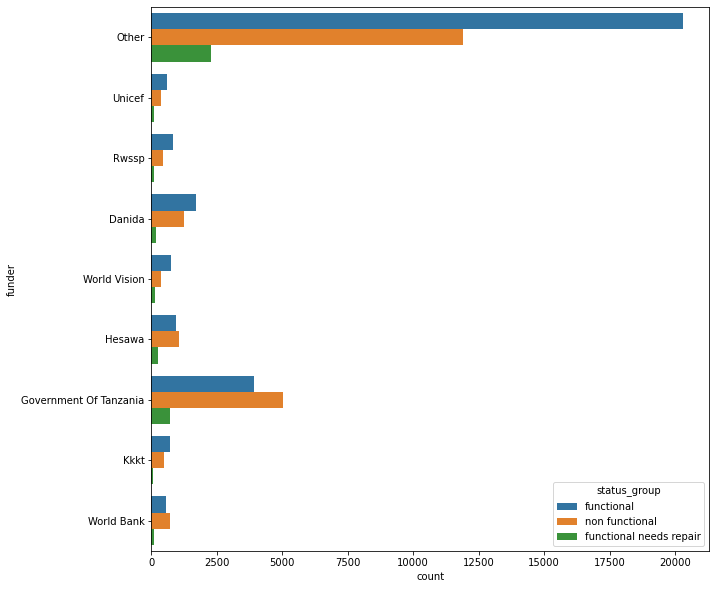

In [19]:
plt.figure(figsize=(10,10))
sns.countplot(y='funder', hue='status_group', data=df)

In [20]:
# groupby_test = df.groupby('funder').agg('count').reset_index()
# groupby_test.head()
# sns.barplot(x='status_group', y='funder', data=groupby_test[groupby_test['status_group'] > 1000])


I have strong reason to believe that 'Government of Tanzania' and 'Ministry of Water' can be lumped into one: https://en.wikipedia.org/wiki/Ministry_of_Water_and_Irrigation

In [21]:
#aggregating
df = df.replace({'installer': 'hesawa'}, 'HESAWA')
df = df.replace({'installer': 'Central government'}, 'Government')
df = df.replace({'installer': 'Commu'}, 'Community')

#cleaning 
df = df.replace({'installer': 'DANID'}, 'DANIDA' )

In [22]:
series = pd.value_counts(df['installer'])
mask = (series/series.sum() * 100).lt(1.75)
df['installer'] = np.where(df['installer'].isin(series[mask].index),'Other',df['installer'])
df['installer'].value_counts()

df = df.replace({'installer': '0'}, 'Other')

In [23]:
df['installer'].value_counts()

Other         31475
DWE           17402
Government     2447
Community      1613
DANIDA         1602
RWE            1206
Name: installer, dtype: int64

<AxesSubplot:xlabel='count', ylabel='installer'>

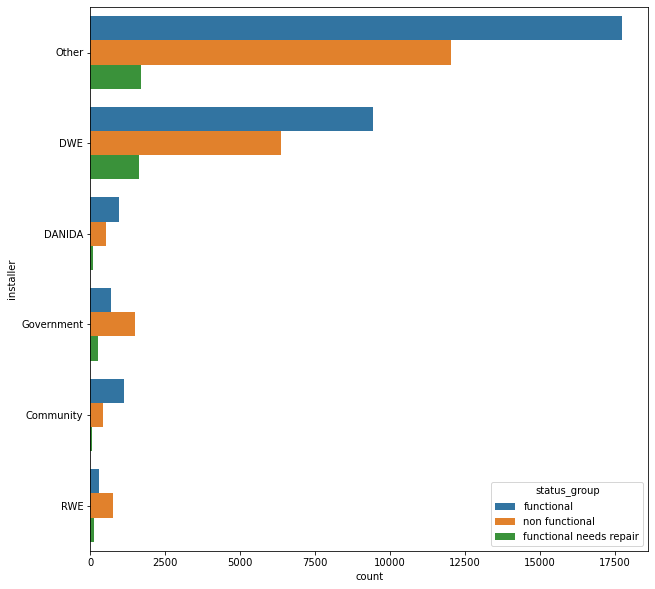

In [24]:
plt.figure(figsize=(10,10))
sns.countplot(y='installer', hue='status_group', data=df)

The following values have been aggregated due to the belief that they were entered with spelling errors

In [25]:
#aggregating
df = df.replace({'wpt_name': 'Shuleni'}, 'School')
df = df.replace({'wpt_name': 'Shule'}, 'School')
df = df.replace({'wpt_name': 'Shule Ya Misingi'}, 'School')

series = pd.value_counts(df['wpt_name'])
mask = (series/series.sum() * 100).lt(1.55)
df['wpt_name'] = np.where(df['wpt_name'].isin(series[mask].index),'Other',df['wpt_name'])

df = df.replace({'wpt_name': 'none'}, 'Other')

In [26]:
df['wpt_name'].value_counts()

Other     57292
School     2108
Name: wpt_name, dtype: int64

<AxesSubplot:xlabel='count', ylabel='wpt_name'>

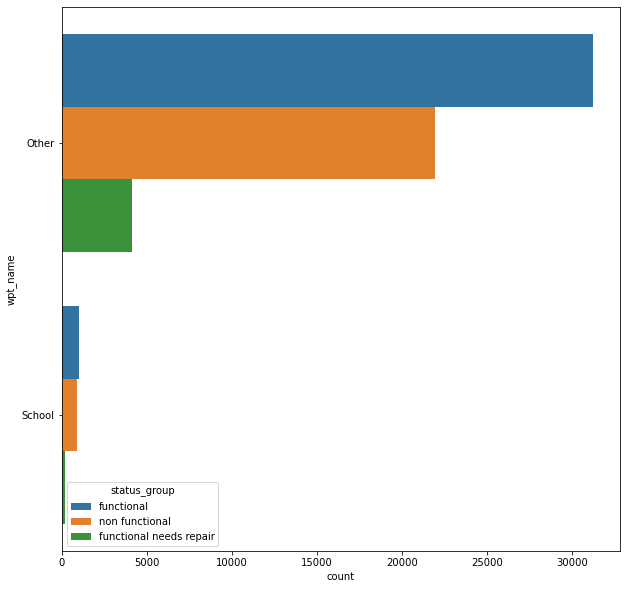

In [27]:
plt.figure(figsize=(10,10))
sns.countplot(y='wpt_name', hue='status_group', data=df)

#### construction_year (missing values)

In [28]:
sorted(df['construction_year'].unique())

[0,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013]

#### well_age

Before I bin the construction_year feature, I am going to make use of what information is given to calculate the age of each well 

In [29]:
df['well_age'] = 2013 - df['construction_year']
df = df.replace({'well_age': 2013}, 100 )

#### binning construction_year

In [30]:
df[(df['construction_year'] < 1970)]['construction_year'].value_counts().sum() - 20709

538

In [31]:
df[(df['construction_year'] < 1980) & (df['construction_year'] > 1969)]['construction_year'].value_counts().sum()

4406

In [32]:
df[(df['construction_year'] < 1990) & (df['construction_year'] > 1979)]['construction_year'].value_counts().sum()

5578

In [33]:
df[(df['construction_year'] < 2000) & (df['construction_year'] > 1989)]['construction_year'].value_counts().sum()

7678

In [34]:
df[(df['construction_year'] < 2010) & (df['construction_year'] > 2000)]['construction_year'].value_counts().sum()

13239

In [35]:
df[(df['construction_year'] >= 2010)]['construction_year'].value_counts().sum()

5161

**OBSERVATION**
1. Nearly half of the entries are missing a construction year
2. Construction year goes back consistantly to 1960
    - I will bin construction years and create a 'null' column during preprocessing
    - BINS = 1960 - 1989, 1990-199, 2000-2009, 2010+

In [36]:
# bins=[-1,1959,1989,1999,2009,2014]

# df['year_constructed']= pd.cut(df['construction_year'],
#                               bins=bins,
#                               labels= ['Unknown','60s - 80s', '1990s', '2000s', '2010+'])

# df.drop('construction_year', axis=1, inplace=True)

#### Assessing Geographic Data

- subvillage 
- region 
- region_code 
- district_code
- lga
- ward 

In [37]:
df['region'].value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [38]:
df['region_code'].value_counts()

11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: region_code, dtype: int64

In [39]:
len(df['region'].unique()) - len(df['region_code'].unique())

-6

In [40]:
df['district_code'].value_counts()

1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: district_code, dtype: int64

In [41]:
len(df['district_code'].unique()) - len(df['region'].unique())

-1

In [42]:
df['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [43]:
df['ward'].value_counts()

Igosi               307
Imalinyi            252
Siha Kati           232
Mdandu              231
Nduruma             217
                   ... 
Mwanga Kaskazini      1
Matarawe              1
Ikweha                1
Mlimani               1
Nyamtinga             1
Name: ward, Length: 2092, dtype: int64

Based upon value counts, it would appear that 'region' will be the cleanest geographical data to work with 

#### Continuous Data

In [44]:
df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,well_age
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,45.406162
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,41.190108
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,9.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,27.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,100.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,100.000000


#### Dealing with Population

In [45]:
df[(df['population'] == 0)]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,management_group,payment_type,quality_group,quantity,source,source_type,source_class,waterpoint_type,status_group,well_age
4,0.0,2011-07-13,Other,0,Other,31.130847,-1.825359,School,0,Lake Victoria,...,other,never pay,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,100
6,0.0,2012-10-01,Other,0,Other,33.362410,-3.766365,Other,0,Internal,...,user-group,never pay,good,enough,machine dbh,borehole,groundwater,hand pump,non functional,100
7,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198,Other,0,Lake Tanganyika,...,user-group,unknown,milky,enough,shallow well,shallow well,groundwater,hand pump,non functional,100
8,0.0,2012-11-03,Other,0,Other,32.711100,-5.146712,Other,0,Lake Tanganyika,...,user-group,never pay,salty,seasonal,machine dbh,borehole,groundwater,hand pump,non functional,100
9,0.0,2011-08-03,Other,0,Other,30.626991,-1.257051,Other,0,Lake Victoria,...,user-group,never pay,good,enough,shallow well,shallow well,groundwater,hand pump,functional,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59384,0.0,2011-07-10,Other,0,Other,30.667805,-2.483710,Other,0,Lake Victoria,...,user-group,never pay,good,insufficient,spring,spring,groundwater,communal standpipe,non functional,100
59392,0.0,2011-04-15,Government Of Tanzania,0,Government,33.009440,-8.520888,Other,0,Lake Rukwa,...,user-group,never pay,good,enough,spring,spring,groundwater,communal standpipe,non functional,100
59393,0.0,2012-10-27,Other,0,Other,33.866852,-4.287410,Other,0,Internal,...,commercial,per bucket,good,insufficient,dam,dam,surface,other,functional,100
59397,0.0,2011-04-11,NaN,0,NaN,34.017087,-8.750434,Other,0,Rufiji,...,user-group,monthly,fluoride,enough,machine dbh,borehole,groundwater,hand pump,functional,100


In [46]:
df['population'].value_counts()

0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
3241        1
1960        1
1685        1
2248        1
1439        1
Name: population, Length: 1049, dtype: int64

Nearly half the data for 'population' is 0 and 1 

My best option is to bin 

In [47]:
#df[(df['population'] < 100) & (df['population'] > 1)]

In [48]:
#df[(df['population'] < 500) & (df['population'] > 1)]

In [49]:
#df[(df['population'] < 200) & (df['population'] > 1)]

In [50]:
#df[(df['population'] > 200) ]

In [51]:
# bins = [-1,1,199,30501]
# df['population_grouped'] = pd.cut(df['population'],
#                                  bins=bins,
#                                  labels=['Unknown', '<200', '>200'])

#### gps_height (Altitude)

In [52]:
df['altitude'] = df['gps_height']
df.drop('gps_height', axis=1, inplace=True)

<AxesSubplot:xlabel='altitude', ylabel='Count'>

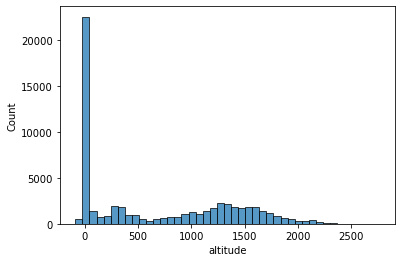

In [53]:
sns.histplot(df['altitude'])

**OBSERVATION**
1. While 0 is an acceptable value for altitude, I do not believe that there are this many wells at an altitude of 0

#### Month Recorded 

Tanzania experiences its wetest season in March/April, and its driest during June/July/August 

The month the status of the well was recorded could be revealing 

In [54]:
df['month_recorded']=pd.to_datetime(df['date_recorded']).dt.month
df['year_recorded']=pd.to_datetime(df['date_recorded']).dt.year


In [55]:
df.drop('date_recorded', axis=1, inplace=True)

In [56]:
df = df[(df['year_recorded']) > 2005]

## Revisitin Null Values 

In [58]:
df

,amount_tsh,funder,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,...,quantity,source,source_type,source_class,waterpoint_type,status_group,well_age,altitude,month_recorded,year_recorded
0,6000.0,Other,Other,34.938093,-9.856322,Other,0,Lake Nyasa,Iringa,11,...,enough,spring,spring,groundwater,communal standpipe,functional,14,1390,3,2011
1,0.0,Other,Other,34.698766,-2.147466,Other,0,Lake Victoria,Mara,20,...,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,3,1399,3,2013
2,25.0,Other,Other,37.460664,-3.821329,Other,0,Pangani,Manyara,21,...,enough,dam,dam,surface,communal standpipe multiple,functional,4,686,2,2013
3,0.0,Unicef,Other,38.486161,-11.155298,Other,0,Ruvuma / Southern Coast,Mtwara,90,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,non functional,27,263,1,2013
4,0.0,Other,Other,31.130847,-1.825359,School,0,Lake Victoria,Kagera,18,...,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,100,0,7,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,10.0,Other,Other,37.169807,-3.253847,Other,0,Pangani,Kilimanjaro,3,...,enough,spring,spring,groundwater,communal standpipe,functional,14,1210,5,2013
59396,4700.0,Other,Other,35.249991,-9.070629,Other,0,Rufiji,Iringa,11,...,enough,river,river/lake,surface,communal standpipe,functional,17,1212,5,2011
59397,0.0,NaN,NaN,34.017087,-8.750434,Other,0,Rufiji,Mbeya,12,...,enough,machine dbh,borehole,groundwater,hand pump,functional,100,0,4,2011
59398,0.0,Other,Other,35.861315,-6.378573,Other,0,Rufiji,Dodoma,1,...,insufficient,shallow well,shallow well,groundwater,hand pump,functional,100,0,3,2011


In [57]:
df.isna().sum()

amount_tsh                  0
funder                   3633
installer                3653
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting           3328
recorded_by                 0
scheme_management        3873
permit                   3055
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment_type                0
quality_group               0
quantity                    0
source                      0
source_type                 0
source_class                0
waterpoint_type             0
status_group                0
well_age                    0
altitude  

In [ ]:
df.info()

In [59]:
df.dropna(inplace=True)

In [60]:
df

,amount_tsh,funder,installer,longitude,latitude,wpt_name,num_private,basin,region,region_code,...,quantity,source,source_type,source_class,waterpoint_type,status_group,well_age,altitude,month_recorded,year_recorded
0,6000.0,Other,Other,34.938093,-9.856322,Other,0,Lake Nyasa,Iringa,11,...,enough,spring,spring,groundwater,communal standpipe,functional,14,1390,3,2011
2,25.0,Other,Other,37.460664,-3.821329,Other,0,Pangani,Manyara,21,...,enough,dam,dam,surface,communal standpipe multiple,functional,4,686,2,2013
3,0.0,Unicef,Other,38.486161,-11.155298,Other,0,Ruvuma / Southern Coast,Mtwara,90,...,dry,machine dbh,borehole,groundwater,communal standpipe multiple,non functional,27,263,1,2013
5,20.0,Other,DWE,39.172796,-4.765587,Other,0,Pangani,Tanga,4,...,enough,other,other,unknown,communal standpipe multiple,functional,4,0,3,2011
6,0.0,Other,Other,33.362410,-3.766365,Other,0,Internal,Shinyanga,17,...,enough,machine dbh,borehole,groundwater,hand pump,non functional,100,0,10,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59394,500.0,World Bank,Other,37.634053,-6.124830,Other,0,Wami / Ruvu,Morogoro,5,...,enough,machine dbh,borehole,groundwater,communal standpipe,non functional,6,351,3,2011
59395,10.0,Other,Other,37.169807,-3.253847,Other,0,Pangani,Kilimanjaro,3,...,enough,spring,spring,groundwater,communal standpipe,functional,14,1210,5,2013
59396,4700.0,Other,Other,35.249991,-9.070629,Other,0,Rufiji,Iringa,11,...,enough,river,river/lake,surface,communal standpipe,functional,17,1212,5,2011
59398,0.0,Other,Other,35.861315,-6.378573,Other,0,Rufiji,Dodoma,1,...,insufficient,shallow well,shallow well,groundwater,hand pump,functional,100,0,3,2011


In [ ]:
df.info()

In [ ]:
df['source_type'].value_counts()

In [ ]:
df['source_class'].value_counts()

In [ ]:
df['source'].value_counts()

In [ ]:
df.drop('source_type', axis=1, inplace=True)

In [ ]:
df['payment_type'].value_counts()

In [ ]:
df['management_group'].value_counts()

In [ ]:
df['extraction_type'].value_counts()

In [ ]:
df['extraction_type_group'].value_counts()

In [ ]:
df.drop('extraction_type', axis=1, inplace=True)

In [ ]:
df['extraction_type_class'].value_counts()

In [ ]:
df['scheme_management'].value_counts()

In [ ]:
df['recorded_by'].value_counts()

In [ ]:
df.drop('recorded_by', axis=1, inplace=True)

In [ ]:
len(df['ward'].unique())

In [ ]:
df.drop('ward', axis=1, inplace=True)

In [ ]:
df['lga'].value_counts()

In [ ]:
df.drop('lga', axis=1, inplace=True)

# EDA

In [ ]:
df.describe()

In [ ]:
sns.countplot(x='status_group', data=df)

**OBSERVATION**
1. There are far more functional wells than non-functional / needs repair
2. I will need to address the class imbalances during preprocessing / modeling 

In [ ]:
sns.scatterplot(x='status_group', y='amount_tsh', data=df)

In [ ]:
tsh_df = df

In [ ]:
tsh_df = tsh_df[(tsh_df['amount_tsh'] < 150000)]

In [ ]:
sns.scatterplot(x='status_group', y='amount_tsh', data=tsh_df)

**OBSERVATION**
1. It would appear that higher amounts of static head correlates with being functional; however it is very likely that this is due to the class imbalance


In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='funder', hue='status_group', data=df)

In [ ]:
df.drop('funder', axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='installer', hue='status_group', data=df)

In [ ]:
df.drop('installer', axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='management_group', hue='status_group', data=df)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='management', hue='status_group', data=df)

In [ ]:
df.drop('management',axis=1, inplace=True)

In [ ]:
sns.scatterplot(x='status_group', y='population', data=df)

In [ ]:
df.groupby('status_group').population.median()

**OBSERVATION**
1. small populations may correlate with non-functional wells, as it may be more imperative that resources are spent on more populous wells 
2. functional wells may have a slightly smaller associated population due to less frequent use 

In [ ]:
sns.scatterplot(x='status_group', y='altitude', data=df)

In [ ]:
age_df = df[(df['well_age'] < 100)]

In [ ]:
sns.scatterplot(x='status_group', y='well_age', data=age_df)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='well_age', hue='status_group', data=df)

**OBSERVATION**
1. there are typically more non-functional wells than functional wells for wells 28 years and over 

In [ ]:
df[(df['population'] > 20000)]['region']

Tanga is a large port city in the NorthEast of Tanzania, this datapoint could make sense
https://en.wikipedia.org/wiki/Tanga,_Tanzania

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='month_recorded', hue='status_group', data=df)

**OBSERVATION**
1. most of the data collected is collected in the first quarter of the year (Jan - March)
2. May, July, September, and December seem to have very little recordings 
3. June - October are the driest seasons: it would appear that there is a spike in recordings halfway through the dry season

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='year_recorded', hue='status_group', data=df)

In [ ]:
df.drop('year_recorded', axis=1, inplace=True)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='quality_group', hue='status_group', data=df)

In [ ]:
quality_df = df[(df['quality_group'] != 'good')]

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='quality_group', hue='status_group', data=quality_df)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='quantity', hue='status_group', data=df)

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='basin', hue='status_group', data=df)

In [ ]:
df.info()

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(y='scheme_management', hue='status_group', data=df)

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=df)

In [ ]:
df.describe()

In [ ]:
df[df['longitude'] == 0]

In [ ]:
df = df[df['longitude'] > 0]

In [ ]:
map_df = df

In [ ]:
map_df = map_df[(map_df['longitude'] > 0)]

In [ ]:
map_df[(map_df['longitude'] == 0)]

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='status_group', data=map_df)

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='population_grouped', data=map_df)

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='region', data=map_df)

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='longitude', y='latitude', hue='basin', data=map_df)

In [ ]:
df

# Modeling 


In [ ]:
df = df.replace({'status_group': 'functional'}, 1)
df = df.replace({'status_group': 'non functional'}, 2)
df = df.replace({'status_group': 'functional needs repair'}, 3)

### Logistic Regression - Baseline 

In [ ]:
#splitting features and target
#creating dummy variables for categorical data
X = df.drop('status_group', axis=1)
X = pd.get_dummies(X, drop_first=True )

y = df['status_group']

In [ ]:
#creating training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .25, random_state=2)

In [ ]:
#scaling 
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# #fitting
# lr_base = LogisticRegression(solver='lbfgs', random_state=2)
# lr_base_model = lr_base.fit(X_train, y_train)

In [ ]:
# lr_base = LogisticRegression(solver='newton-cg', random_state=2)
# lr_base_model = lr_base.fit(X_train, y_train)

In [ ]:
lr_base = LogisticRegression(solver='sag', random_state=2, max_iter=1000)
lr_base_model = lr_base.fit(X_train_scaled, y_train)

In [ ]:
# lr_base = LogisticRegression(solver='saga', random_state=2)
# lr_base_model = lr_base.fit(X_train, y_train)

In [ ]:
print(confusion_matrix(y_test, lr_base.predict(X_test_scaled)))

In [ ]:
plot_confusion_matrix(lr_base, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
y_test.value_counts()

In [ ]:
print(classification_report(y_test, lr_base.predict(X_test_scaled)))

**OBSERVATION** 
1. As expected, class imbalance has made the baseline model guess functional (1) very frequently, and functional in need of repair (3) very little 

### Logistic Regression - Gridsearch Optimization

In [ ]:
sns.countplot(x='status_group', data=df)

In [ ]:
y.value_counts()

In [ ]:
18017/26127

In [ ]:
26127/18017

In [ ]:
3160/26127

In [ ]:
26127/3160

In [ ]:
lr_v2 = LogisticRegression(solver='sag', random_state=2, max_iter=4000)

weight_dict = {2: 1.5, 3:8}

param_grid = {
    'class_weight': [None, 'balanced', weight_dict],
    'C': [1.0, 500, 1e12]
}

lr_v2_model = GridSearchCV(estimator = lr_v2, param_grid=param_grid, cv=2)
lr_v2_model.fit(X_train_scaled, y_train)

In [ ]:
lr_v2_model.best_params_

In [ ]:
param_grid

## Decision Tree Baseline 

In [ ]:
dt_base = DecisionTreeClassifier()

dt_base_model = dt_base.fit(X_train_scaled, y_train)

In [ ]:
# fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
# tree.plot_tree(dt_base,
#                feature_names = X.columns, 
#                class_names=np.unique(y).astype('str'),
#                filled = True)
# plt.show()

In [ ]:
print(classification_report(y_train, dt_base.predict(X_train_scaled)))

**INTERPRETATION**
1. Extremely Overfit. The model knows the training data completely 

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (20,15), dpi=300)
tree.plot_tree(dt_base,
               feature_names = X.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

**OBSERVATION**
1. The long tails indicate the overfitting

In [ ]:
plot_confusion_matrix(dt_base, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

**INTERPRETATION**
1. 2/3 is worst case scenario (predicted non functional, but is actually in need of repair)
2. 3/1 is pretty bad (predicted in need of repair, but is actually working) 

In [ ]:
print(classification_report(y_test, dt_base.predict(X_test_scaled)))

**INTERPRETATION**
1. comparing this test report to the train report, Accuracy = 0.76 (a drop of 23%) tells me that the model is very overfit 

In [ ]:
print(dt_base.tree_.max_depth)

## Decision Tree - Gridsearch

In [ ]:
dt_v2 = DecisionTreeClassifier()

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 0.5, 2: 3, 3: 10}
weight_dict3 = {1: 0.25, 2: 6, 3: 12}

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'class_weight': [weight_dict, weight_dict2, weight_dict3, 'balanced'],
    'max_depth' : [10, 20, 30],
    'min_samples_split' : [1.0, 3, 5],
    'min_samples_leaf' : [10, 15, 30]
}

dt_v2_model = GridSearchCV(estimator = dt_v2, param_grid=param_grid, cv=3)
dt_v2_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v2_model.best_params_)

In [ ]:
print(classification_report(y_train, dt_v2_model.predict(X_train_scaled)))

In [ ]:
plot_confusion_matrix(dt_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, dt_v2_model.predict(X_test_scaled)))

In [ ]:
dt_v3 = DecisionTreeClassifier(criterion= 'entropy')

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 0.5, 2: 1.5, 3: 8}

param_grid = {
    'class_weight': [weight_dict, weight_dict2],
    'max_depth' : [25, 30, 35],
    'min_samples_split' : [3, 5],
    'min_samples_leaf' : [9, 10, 11]
}

dt_v3_model = GridSearchCV(estimator = dt_v3, param_grid=param_grid, cv=3)
dt_v3_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v3_model.best_params_)

In [ ]:
plot_confusion_matrix(dt_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
print(classification_report(y_test, dt_v3_model.predict(X_test_scaled)))

In [ ]:
dt_v4 = DecisionTreeClassifier(criterion= 'entropy', max_depth=30)

weight_dict = {1: 1, 2: 1.5, 3: 8}
weight_dict2 = {1: 1, 2: 3, 3: 10}

param_grid = {
    'class_weight': [weight_dict, weight_dict2],
    'min_samples_split' : [2, 3],
    'min_samples_leaf' : [7, 8, 9]
}

dt_v4_model = GridSearchCV(estimator = dt_v4, param_grid=param_grid, cv=3)
dt_v4_model.fit(X_train_scaled, y_train)

In [ ]:
print(dt_v4_model.best_params_)

In [ ]:
print(classification_report(y_test, dt_v4_model.predict(X_test_scaled)))

### Decision Tree - SMOTE

Thus far I have onl been dealing with class imbalance by adjusting 'class_weight' in gridsearch. While this is a valid technique, I am seeing little improvement. Using SMOTE to create new synthetic data, rather than simply giving more weight to the minority classes (2 and 3), might yield useful insight.

In [ ]:
#creating training and testing data
# X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_sm, y_sm, test_size= .25, random_state=2)

In [ ]:
sm = SMOTE(random_state=2)

X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)


In [ ]:
#scaling 
scaler = StandardScaler()

X_train_scaled_sm = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

In [ ]:
dt_smote = DecisionTreeClassifier(max_depth=30)
dt_smote_model = dt_smote.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(classification_report(y_train_sm, dt_smote_model.predict(X_train_scaled_sm)))

In [ ]:
print(dt_smote.tree_.max_depth)

In [ ]:
print(classification_report(y_test, dt_smote_model.predict(X_test_scaled)))

### Decision Tree - Smote(2)

In [ ]:
dt_smote_v2 = DecisionTreeClassifier()


param_grid = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [10, 20, 25],
    'min_samples_split' : [1.0, 10, 20, 30],
    'min_samples_leaf' : [5, 10, 15]
}

dt_smote_v2_model = GridSearchCV(estimator = dt_smote_v2, param_grid=param_grid, cv=3)
dt_smote_v2_model.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(dt_smote_v2_model.best_params_)

In [ ]:
print(classification_report(y_train_sm, dt_smote_v2_model.predict(X_train_scaled_sm)))

In [ ]:
print(classification_report(y_test, dt_smote_v2_model.predict(X_test_scaled)))

In [ ]:
dt_smote_v4 = DecisionTreeClassifier(max_depth=25, min_samples_leaf=5, min_samples_split=10)

In [ ]:
dt_smote_v4.fit(X_train_scaled_sm, y_train_sm)

In [ ]:
print(classification_report(y_train_sm, dt_smote_v4.predict(X_train_scaled_sm)))

In [ ]:
print(classification_report(y_test, dt_smote_v4.predict(X_test_scaled)))

**INTERPRETATION**
1. 3 is still extremely overfit, but other classes are performing okay (still some overfitting)
2. Looking at overall performance across all classes, this is my best Decision Tree

## Random Forest - Baseline 

In [ ]:
forest_base = RandomForestClassifier()
forest_base_model = forest_base.fit(X_train_scaled, y_train)

In [ ]:
print(classification_report(y_train, forest_base_model.predict(X_train_scaled)))

In [ ]:
print(classification_report(y_test, forest_base_model.predict(X_test_scaled)))

In [ ]:
print(forest_base.tree_.max_depth)

**INTERPRETATION**
1. Completely overfit, just like the Decision Tree basemodel 

In [ ]:
forest_v2 = RandomForestClassifier(criterion='entropy', 
                                   class_weight= {1: 1, 2: 1.5, 3: 8}, 
                                   max_depth=35, 
                                   min_samples_leaf= 15, 
                                   min_samples_split= 7)

forest_v2_model= forest_v2.fit(X_train_scaled, y_train)

In [ ]:
print(classification_report(y_train, forest_v2_model.predict(X_train_scaled)))

In [ ]:
print(classification_report(y_test, forest_v2_model.predict(X_test_scaled)))

In [ ]:
plot_confusion_matrix(forest_v2_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()

In [ ]:
forest_v3 = RandomForestClassifier(criterion='entropy', 
                                   class_weight= {1: 1, 2: 1.5, 3: 8}, 
                                   max_depth=35, 
                                   min_samples_leaf= 15, 
                                   min_samples_split= 7,)

param_grid = {
    'max_features': [10, 50, 100],
    'n_estimators': [20, 50, 100]
}

forest_v3_model = GridSearchCV(estimator = forest_v3, param_grid=param_grid, cv=3)
forest_v3_model.fit(X_train_scaled, y_train)

In [ ]:
print(forest_v3_model.best_params_)

In [ ]:
print(classification_report(y_train, forest_v3_model.predict(X_train_scaled)))

In [ ]:
print(classification_report(y_test, forest_v3_model.predict(X_test_scaled)))

In [ ]:
plot_confusion_matrix(forest_v3_model, X_test_scaled, y_test,
                     cmap=plt.cm.Blues)
plt.show()